In [1]:
#coding:utf8
import matplotlib
import os
if 'DISPLAY' not in os.environ:
    matplotlib.use('Agg')
else:
    pass
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy
from utils import Predicate,Clause,KnowledgeBase, Propositional
from utils import load_knowledge_base,load_propositional
from models import LTN
import pickle
import numpy as np
import seaborn as sns
sns.set(style="white", context="talk")
from utils import get_DF,show_learned_propositionals

In [3]:
kb1=load_knowledge_base('./facts1.txt')
kb2=load_knowledge_base('./facts2.txt')
propositionals=load_propositional('./knowledge.txt')
gkbs1=[]
for p in propositionals:
    gkbs1.append(p.generate_knowledge_base('abcdefgh',change_weight=False))
gkb1=gkbs1[0]
for tkb in gkbs1[1:]:
    gkb1=gkb1.union(tkb)
gkbs2=[]
for p in propositionals:
    gkbs2.append(p.generate_knowledge_base('ijklmn',change_weight=False))
gkb2=gkbs2[0]
for tkb in gkbs2[1:]:
    gkb2=gkb2.union(tkb)

gkbs3=[]
for p in propositionals:
    gkbs3.append(p.generate_knowledge_base('abcdefgh',change_weight=True))
gkb3=gkbs3[0]
for tkb in gkbs3[1:]:
    gkb3=gkb3.union(tkb)
gkbs4=[]
for p in propositionals:
    gkbs4.append(p.generate_knowledge_base('ijklmn',change_weight=True))
gkb4=gkbs4[0]
for tkb in gkbs4[1:]:
    gkb4=gkb4.union(tkb)

In [4]:
def get_accuracy(model,kb):
    results=[]
    for clause in kb.clauses:
        o1,o2=model.forward(clause)
        if o2.data.numpy()[0][0]>0.9:
            results.append(1.0)
        else:
            results.append(0.0)

    return sum(results)/len(kb.clauses)

In [5]:
def test_model(model, kb1, kb2, filename):
    kb_train = kb1.union(kb2)
    optimizor = torch.optim.Adam(model.parameters(), lr=0.001)
    mone = torch.FloatTensor([-1])
    one = torch.FloatTensor([1])
    average_prob = []
    averate_loss = []
    best_accuracy1 = 0.0
    best_accuracy2 = 0.0
    best_table1 = None
    best_table2 = None
    best_table3 = None
    for i in tqdm(range(1000)):
        optimizor.zero_grad()
        total_probability = 0.0
        total_loss = 0.0
        for clause in kb_train.clauses:
            loss, prob = model.forward(clause=clause)
            loss.backward(one)
            total_probability += prob.data.numpy()[0]
            total_loss += loss.data.numpy()[0]
        optimizor.step()
        average_prob.append(total_probability / len(kb_train.clauses))
        averate_loss.append(total_loss / len(kb_train.clauses))
        accuracy1 = get_accuracy(model, kb1)
        accuracy2 = get_accuracy(model, kb2)
        if accuracy1 + accuracy2 > best_accuracy1 + best_accuracy2:
            best_accuracy1 = accuracy1
            best_accuracy2 = accuracy2
            best_table1 = get_DF(model, 'abcdefgh')
            best_table2 = get_DF(model, 'ijklmn')
            best_table3 = show_learned_propositionals(model, propositionals)
    pickle.dump((average_prob, averate_loss, best_accuracy1, best_accuracy2,
                 best_table1, best_table2, best_table3),
                open("./results/%s" % filename, "wb"))

In [6]:
emb_dim=50

In [6]:
test_model(
    model=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]], CLTN=False),
    kb1=kb1,
    kb2=kb2,
    filename='result1.pkl'
)

  0%|          | 2/1000 [00:02<20:24,  1.23s/it]


TypeError: generate_knowledge_base() missing 1 required positional argument: 'change_weight'

In [7]:
test_model(
    model=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]], CLTN=True),
    kb1=kb1,
    kb2=kb2,
    filename='result2.pkl'
)

100%|██████████| 1000/1000 [03:26<00:00,  4.85it/s]


In [24]:
test_model(
    model=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]], CLTN=False),
    kb1=kb1.union(gkb1),
    kb2=kb2.union(gkb2),
    filename='result5.pkl'
)

100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


In [10]:
test_model(
    model=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]], CLTN=True),
    kb1=kb1.union(gkb1),
    kb2=kb2.union(gkb2),
    filename='result6.pkl'
)

100%|██████████| 1000/1000 [24:55<00:00,  1.50s/it]


In [26]:
test_model(
    model=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]], CLTN=False),
    kb1=kb1.union(gkb3),
    kb2=kb2.union(gkb4),
    filename='result7.pkl'
)

100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


In [19]:
test_model(
    model=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]], CLTN=True),
    kb1=kb1.union(gkb3),
    kb2=kb2.union(gkb4),
    filename='result8.pkl'
)

100%|██████████| 1000/1000 [1:19:55<00:00,  4.80s/it]


In [7]:
prob1,loss1,first1,second1=pickle.load(open('./results/result1.pkl','rb'),encoding='latin1')
prob2,loss2,first2,second2=pickle.load(open('./results/result2.pkl','rb'),encoding='latin1')

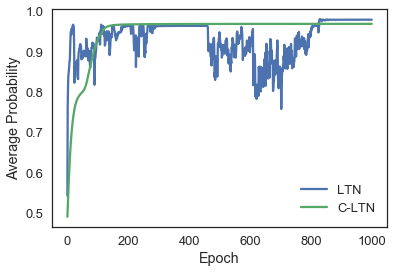

In [8]:
plt.plot(prob1,label='LTN')
plt.plot(prob2,label='C-LTN')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Probability')
plt.savefig('./Report/img/curve1.pdf')
plt.show()

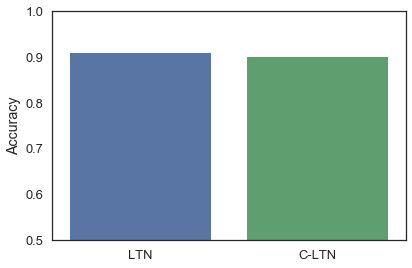

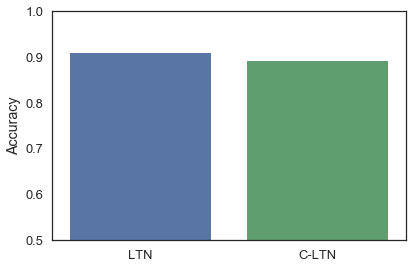

In [4]:
x = np.array(['LTN','C-LTN'])
y1 = np.array([first1,first2])
y2 = np.array([second1,second2])
sns.barplot(x, y1)
plt.ylabel("Accuracy")
plt.ylim((0.5,1.0))
plt.savefig('./Report/img/bar1.pdf')
plt.tight_layout()
plt.show()

sns.barplot(x, y2)
plt.ylabel("Accuracy")
plt.ylim((0.5,1.0))
plt.savefig('./Report/img/bar2.pdf')
plt.tight_layout()
plt.show()

In [9]:
prob1,loss1,first1,second1=pickle.load(open('./results/result5.pkl','rb'),encoding='latin1')
prob2,loss2,first2,second2=pickle.load(open('./results/result6.pkl','rb'),encoding='latin1')
prob3,loss3,first3,second3=pickle.load(open('./results/result7.pkl','rb'),encoding='latin1')
prob4,loss4,first4,second4=pickle.load(open('./results/result8.pkl','rb'),encoding='latin1')

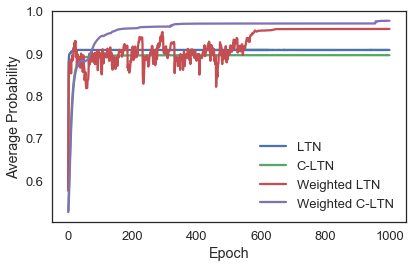

In [10]:
plt.plot(prob1,label='LTN')
plt.plot(prob2,label='C-LTN')
plt.plot(prob3,label='Weighted LTN')
plt.plot(prob4,label='Weighted C-LTN')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Probability')
plt.savefig('./Report/img/curve2.pdf')
plt.tight_layout()
plt.show()

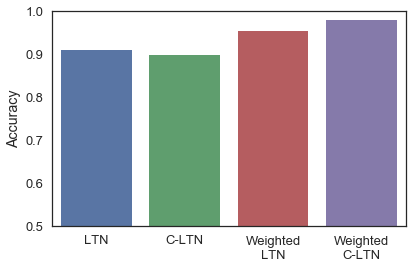

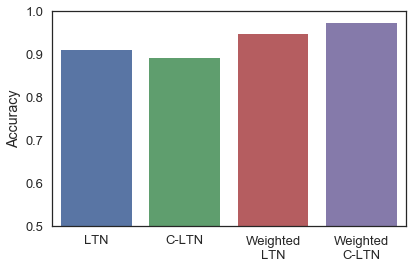

In [12]:
x = np.array(['LTN','C-LTN','Weighted\nLTN','Weighted\nC-LTN'])
y1 = np.array([first1,first2,first3,first4])
y2 = np.array([second1,second2,second3,second4])
sns.barplot(x, y1)
plt.ylabel("Accuracy")
plt.ylim((0.5,1.0))
plt.savefig('./Report/img/bar3.pdf')
plt.tight_layout()
plt.show()

sns.barplot(x, y2)
plt.ylabel("Accuracy")
plt.ylim((0.5,1.0))
plt.savefig('./Report/img/bar4.pdf')
plt.tight_layout()
plt.show()

In [14]:
emb_dim_range=list(range(10,20,5))+list(range(20,201,20))

In [26]:
for emb_dim in emb_dim_range:
    test_model(
        model=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]], CLTN=True),
        kb1=kb1,
        kb2=kb2,
        filename='LTN_emb_dim=%d.pkl'%(emb_dim)
    )

100%|██████████| 1000/1000 [22:29<00:00,  1.35s/it]


In [31]:
for emb_dim in emb_dim_range:
    test_model(
        model=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]], CLTN=True),
        kb1=kb1.union(gkb3),
        kb2=kb2.union(gkb4),
        filename='LTN_Learn_emb_dim=%d.pkl'%(emb_dim)
    )

  0%|          | 3/1000 [00:16<1:29:53,  5.41s/it]

KeyboardInterrupt: 

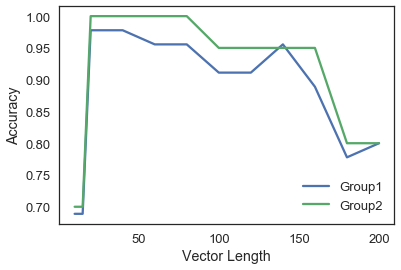

In [15]:
accuracys1=[]
accuracys2=[]
for emb_dim in emb_dim_range:
    prob,loss,first,second=pickle.load(open('./results/LTN_emb_dim=%d.pkl'%(emb_dim),'rb'),encoding='latin1')
    accuracys1.append(first)
    accuracys2.append(second)
plt.plot(emb_dim_range,accuracys1,label='Group1')
plt.plot(emb_dim_range,accuracys2,label='Group2')
plt.legend()
plt.xlabel('Vector Length')
plt.ylabel('Accuracy')
plt.savefig('./Report/img/curve3.pdf')
plt.show()

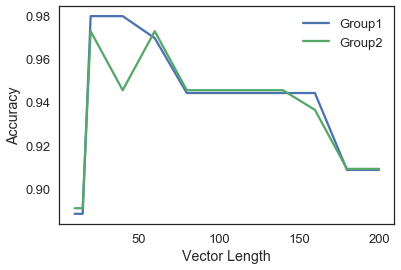

In [18]:
accuracys1=[]
accuracys2=[]
for emb_dim in emb_dim_range:
    prob,loss,first,second=pickle.load(open('./results/LTN_Learn_emb_dim=%d.pkl'%(emb_dim),'rb'),encoding='latin1')
    accuracys1.append(first)
    accuracys2.append(second)
plt.plot(emb_dim_range,accuracys1,label='Group1')
plt.plot(emb_dim_range,accuracys2,label='Group2')
plt.legend()
plt.xlabel('Vector Length')
plt.ylabel('Accuracy')
plt.savefig('./Report/img/curve4.pdf')
plt.show()

In [21]:
prob,loss,first,second,best_table1,best_table2,best_table3=pickle.load(open('./results/result2.pkl','rb'),encoding='latin1')

In [22]:
best_table1

,S,C,a,b,c,d,e,f,g,h
a,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00
b,0.00,0.00,1.00,0.11,1.00,0.00,0.00,0.00,0.00,0.00
c,0.00,0.00,0.00,1.00,0.01,1.00,0.00,0.00,0.00,0.00
d,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
e,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
f,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.01,0.00,0.00
g,0.14,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.08,1.00
h,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [23]:
best_table2

,S,C,i,j,k,l,m,n
i,1.00,0.05,0.74,1.00,0.01,0.01,1.00,0.00
j,0.00,0.02,1.00,0.00,0.00,0.00,0.00,0.00
k,0.00,0.09,0.01,0.00,0.02,0.90,0.01,0.03
l,0.00,0.02,0.01,0.00,0.90,0.01,0.01,0.01
m,0.00,0.11,1.00,0.00,0.01,0.01,0.51,1.00
n,1.00,0.05,0.00,0.00,0.03,0.01,1.00,0.02


In [24]:
best_table3

,Propositional,Group1,Group2
0,"¬F(x, x)",0.75,0.666667
1,"¬F(x, y) ∨ F(y, x)",0.984375,0.944444
2,"F(x, y)",1,1
3,"¬S(x) ∨ ¬F(x, y) ∨ S(y)",0.953125,0.916667
4,¬S(x) ∨ C(x),0.75,0.666667


In [25]:
prob,loss,first,second,best_table1,best_table2,best_table3=pickle.load(open('./results/result8.pkl','rb'),encoding='latin1')

In [26]:
best_table1

,S,C,a,b,c,d,e,f,g,h
a,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
b,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
c,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
d,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
e,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
f,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
g,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
h,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [27]:
best_table2

,S,C,i,j,k,l,m,n
i,1.00,0.99,0.00,0.00,0.00,0.00,0.00,0.00
j,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.00
k,0.00,0.54,0.00,0.00,0.00,0.00,0.00,0.00
l,0.00,0.70,0.00,0.00,0.00,0.00,0.00,0.00
m,0.00,0.83,0.00,0.00,0.00,0.00,0.00,0.00
n,1.00,0.91,0.00,0.00,0.00,0.00,0.00,0.00


In [28]:
best_table3

,Propositional,Group1,Group2
0,"¬F(x, x)",1,1
1,"¬F(x, y) ∨ F(y, x)",1,1
2,"F(x, y)",0,0
3,"¬S(x) ∨ ¬F(x, y) ∨ S(y)",1,1
4,¬S(x) ∨ C(x),0.875,1
